<center>
    <h1><b><font color="blue"> Notebook 1 - Préprocessing</font> </b></h1>
</center>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import DistanceMetric
from math import radians

# 1. Import des fichiers de travail

## Chargements des jeux de données :
 - df : données météo en australie sur 10 ans
 - aus_town_gps : localisation des stations météo (x,y) => ce jeu de données va nous permettre de représenter les indicateurs sur une carte et de calculer des distances entre stations météo
 - climatsaus : climat des stations méteo 

In [3]:
df = pd.read_csv("weatherAUS.csv")
aus_town_gps = pd.read_csv("aus_town_gps.csv",sep=",")
climatsaus = pd.read_csv("climatsAUS_v2.csv",sep=";")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [5]:
df.describe(include='object')

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
count,145460,145460,135134,134894,141232,142199,142193
unique,3436,49,16,16,16,2,2
top,2013-11-12,Canberra,W,N,SE,No,No
freq,49,3436,9915,11758,10838,110319,110316


<hr>
<h3>Decription du jeu de données :</h3>
<hr>

Le jeu de données possède 145 460 entrées et 23 colonnes dont :
- La date de l'observation.
- La ville dans laquelle se situe la station météo.
- 20 variables décrivant les conditions atmosphériques du jour de l’observation. *
- La variable cible RainTomorrow dont la valeur (Yes ou No) indique s'il a plu le lendemain de l'observation.

*Le jeu de données contient un mélange de variables explicatives catégorielles (type object) et de variables explicatives numériques (type float64) :
- 14 variables continues : MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine, WindGustSpeed, WindSpeed9am, WindSpeed3pm, Humidity9am, Humidity3pm, Pressure9am, Pressure3pm, Temp9am, Temp3pm
- 2 variables discrètes (Nombre d'octas, de 0 à 9) : Cloud9am, Cloud3pm
- 4 variables catégorielles non-numériques : WinGustDir, WindDir3am, WindDir3pm, RainToday.
- Les valeurs de la variable RainToday (Yes, No) sont définies par la variable Rainfall (Yes si précipitations > 1mm)*

Plusieurs variables possèdent de nombreuses valeurs manquantes qu'il faudra gérer.

Le jeu de données comporte 3436 journées d'observations météorologiques (entre décembre 2008 et juin 2017) réalisées par 49 stations météo (Location).

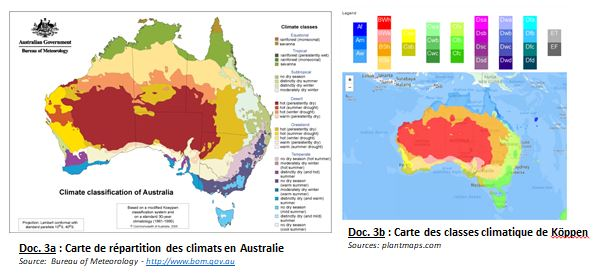


# 2. Création de nouvelles variables

 ## a. Conversion de raintoday et raintomorrow en données numériques

In [4]:
#création de quelques variables de date et conversion de raintoday et raintomorrow en numériques
df['RainToday_Num'] = (df['RainToday'] ==  'Yes')*1
df['RainTomorrow_Num'] = (df['RainTomorrow'] ==  'Yes')*1
df['Date'] = pd.to_datetime(df['Date'])
df['Mois'] = df['Date'].dt.month
df['Trimestre'] = df['Date'].dt.quarter
df['Annee'] = df['Date'].dt.year

## b. Numérisation des vents - Etape 1

Les variables WindGustDir, WindDir9am et WindDir3pm indiquent la direction des vents sous forme de points cardinaux (32 modalités : voir Doc. 4). 
L’objectif est de numériser ces variables afin d’indiquer la direction W-E et S-N des vents.
Une première série de trois variables est créée dans la but d’indiquer l’angle du vent en degré selon la position du point d’origine du vent sur le cercle trigonométrique (WinGust_Ang,…).
Deux autres séries de trois variables sont ensuite calculées à partir de l’angle (WinGust_cos,… et WindGust_sin…). Elles indiquent le cosinus et le sinus de l’angle, autrement dit la direction W-E et S-N du vent (voir Doc. 5) : 
-	Un cosinus négatif correspond à un vent d’ouest, alors qu’un cosinus positif correspond à un vent d’est.
-	Un sinus négatif correspond à un vent de sud, alors qu’un sinus positif correspond à un vent de nord

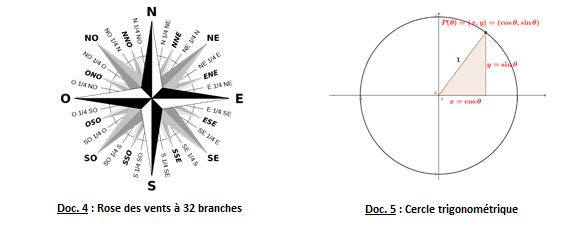

In [7]:
#création d'un dictionnaire associant la direction du vent à l'angle correspondant (en degrés) sur le cercle trigonométrique (ie. E=0° et rotation dans le sens direct)
angles = {'E':0, 
          'ENE':22.5, 
          'NE':45, 
          'NNE':67.5, 
          'N':90, 
          'NNW':112.5, 
          'NW':135, 
          'WNW':157.5, 
          'W':180, 
          'WSW':202.5, 
          'SW':225, 
          'SSW':247.5, 
          'S':270, 
          'SSE':292.5, 
          'SE':315, 
          'ESE':337.5}

#ajout des variables indiquant l'angle du vent au DF
df['WindGust_Ang']=df['WindGustDir'].map(angles)
df['Wind9am_Ang'] = df['WindDir9am'].map(angles)
df['Wind3pm_Ang'] = df['WindDir3pm'].map(angles)


## c. Numérisation des vents - Etape 2

In [6]:

#ajout de variables correspondant au cosinos de l'angle (abscisse des coordonnées trigo). Un cosinus négatif correspond à un vent d'ouest, un cosinus positif à un vent d'est.
df['WindGust_cos'] = np.cos(np.radians(df['WindGust_Ang']))
df['Wind9am_cos'] = np.cos(np.radians(df['Wind9am_Ang']))
df['Wind3pm_cos'] = np.cos(np.radians(df['Wind3pm_Ang']))

#ajout de variables correspondant au sinus de l'angle (ordonnée des coordonnées trigo). Un sinus négatif correspond à un vent de sud, un sinus positif à un vent de nord.
df['WindGust_sin'] = np.sin(np.radians(df['WindGust_Ang']))
df['Wind9am_sin'] = np.sin(np.radians(df['Wind9am_Ang']))
df['Wind3pm_sin'] = np.sin(np.radians(df['Wind3pm_Ang']))

## d. Suppression colonnes catégorielles suite à numérisation

In [7]:
df=df.drop(['WindGustDir','WindDir9am','WindDir3pm','RainToday','RainTomorrow'],axis=1)

# 4. Fusion des différents dataframes

## a. Création d'un regroupement des climats existants

In [8]:
# Pour simplifier, on regroupe les climats en 4 catégories : chaud_humide, tempéré_froid, sec et méditerranéen. On pourra ainsi faire des visualisations plus facilement.

climats_type = {'Am':'tropical',
                'Aw':'tropical',
                'Cfa':'subtropical',
                'Cfb':'océanique', 
                'Cfc':'océanique', 
                'BSh':'sec',
                'BSk':'sec',
                'Bsk':'sec', 
                'Bwh':'sec',
                'Csa':'méditerranéen',
                'Csb':'méditerranéen'              
               }

clim_type_det = {'Am':'mousson',
                'Aw':'savane',
                'Cfa':'Subtropical humide',
                'Cfb':'Océanique/été tempéré', 
                'Cfc':'Océanique/été court et frais', 
                'BSh':'Semi-aride/sec et chaud',
                'BSk':'Semi-aride/sec et froid',
                'Bsk':'Semi-aride/sec et froid', 
                'Bwh':'Désertique/sec et chaud',
                'Csa':'Méditerranéen/été chaud',
                'Csb':'Méditerranéen/été tempéré'              
               }


climatsaus['Clim_type']=climatsaus['Climat_Koppen'].map(climats_type)
climatsaus['Clim_type_det']=climatsaus['Climat_Koppen'].map(clim_type_det)

## b. Fusion des dataframes

In [9]:
#Fusion des dataframes

df = pd.merge(df, aus_town_gps, how='left', left_on="Location",right_on="Location")
df = pd.merge(df, climatsaus, how='left', left_on="Location",right_on="Location")
df.head(10)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,...,WindGust_cos,Wind9am_cos,Wind3pm_cos,WindGust_sin,Wind9am_sin,Wind3pm_sin,Latitude,Longitude,Climat_Koppen,Clim_type
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,44.0,20.0,24.0,...,-1.000000,-1.000000e+00,-0.923880,1.224647e-16,1.224647e-16,3.826834e-01,-36.065766,146.910315,Cfa,subtropical
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,44.0,4.0,22.0,...,-0.923880,-3.826834e-01,-0.923880,3.826834e-01,9.238795e-01,-3.826834e-01,-36.065766,146.910315,Cfa,subtropical
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,46.0,19.0,26.0,...,-0.923880,-1.000000e+00,-0.923880,-3.826834e-01,1.224647e-16,-3.826834e-01,-36.065766,146.910315,Cfa,subtropical
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,24.0,11.0,9.0,...,0.707107,7.071068e-01,1.000000,7.071068e-01,-7.071068e-01,0.000000e+00,-36.065766,146.910315,Cfa,subtropical
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,41.0,7.0,20.0,...,-1.000000,9.238795e-01,-0.707107,1.224647e-16,3.826834e-01,7.071068e-01,-36.065766,146.910315,Cfa,subtropical
5,2008-12-06,Albury,14.6,29.7,0.2,NaN,NaN,56.0,19.0,24.0,...,-0.923880,-1.000000e+00,-1.000000,3.826834e-01,1.224647e-16,1.224647e-16,-36.065766,146.910315,Cfa,subtropical
6,2008-12-07,Albury,14.3,25.0,0.0,NaN,NaN,50.0,20.0,24.0,...,-1.000000,-7.071068e-01,-1.000000,1.224647e-16,-7.071068e-01,1.224647e-16,-36.065766,146.910315,Cfa,subtropical
7,2008-12-08,Albury,7.7,26.7,0.0,NaN,NaN,35.0,6.0,17.0,...,-1.000000,3.826834e-01,-1.000000,1.224647e-16,-9.238795e-01,1.224647e-16,-36.065766,146.910315,Cfa,subtropical
8,2008-12-09,Albury,9.7,31.9,0.0,NaN,NaN,80.0,7.0,28.0,...,-0.382683,7.071068e-01,-0.707107,9.238795e-01,-7.071068e-01,7.071068e-01,-36.065766,146.910315,Cfa,subtropical
9,2008-12-10,Albury,13.1,30.1,1.4,NaN,NaN,28.0,15.0,11.0,...,-1.000000,-1.836970e-16,0.382683,1.224647e-16,-1.000000e+00,-9.238795e-01,-36.065766,146.910315,Cfa,subtropical


## d. Ajout des variables Rain_J-1, Rain_J-2, Rain_J+2, Rain_J+3

In [10]:
df= df.sort_values(["Location","Date"])
df["Rain_J-1"] = df["RainToday_Num"].shift(1)
df["Rain_J-2"] = df["RainToday_Num"].shift(2)
df["Rain_J+2"] = df["RainToday_Num"].shift(-2)
df["Rain_J+3"] = df["RainToday_Num"].shift(-3)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145460 entries, 96320 to 108570
Data columns (total 40 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              145460 non-null  datetime64[ns]
 1   Location          145460 non-null  object        
 2   MinTemp           143975 non-null  float64       
 3   MaxTemp           144199 non-null  float64       
 4   Rainfall          142199 non-null  float64       
 5   Evaporation       82670 non-null   float64       
 6   Sunshine          75625 non-null   float64       
 7   WindGustSpeed     135197 non-null  float64       
 8   WindSpeed9am      143693 non-null  float64       
 9   WindSpeed3pm      142398 non-null  float64       
 10  Humidity9am       142806 non-null  float64       
 11  Humidity3pm       140953 non-null  float64       
 12  Pressure9am       130395 non-null  float64       
 13  Pressure3pm       130432 non-null  float64       
 14  

## e. Transformation de la variable circulaire Mois en variable numérique

In [12]:
df['Mois_sin'] = df['Mois'].apply(lambda m: np.sin(2 * np.pi * (m-1)/11)) 
df['Mois_cos'] = df['Mois'].apply(lambda m: np.cos(2 * np.pi * (m-1)/11)) 

## f. Transformation de la variable des climats (Clim_type) en variable indicatrice

In [13]:
clim_indic = pd.get_dummies(df.Clim_type, prefix='clim')
df = df.join(clim_indic).drop('Clim_type', axis=1)

In [14]:
df.to_csv('weatherAUS_nan.csv')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145460 entries, 96320 to 108570
Data columns (total 46 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Date                145460 non-null  datetime64[ns]
 1   Location            145460 non-null  object        
 2   MinTemp             143975 non-null  float64       
 3   MaxTemp             144199 non-null  float64       
 4   Rainfall            142199 non-null  float64       
 5   Evaporation         82670 non-null   float64       
 6   Sunshine            75625 non-null   float64       
 7   WindGustSpeed       135197 non-null  float64       
 8   WindSpeed9am        143693 non-null  float64       
 9   WindSpeed3pm        142398 non-null  float64       
 10  Humidity9am         142806 non-null  float64       
 11  Humidity3pm         140953 non-null  float64       
 12  Pressure9am         130395 non-null  float64       
 13  Pressure3pm         13043

# 3. Gestion des NA du dataframe df

In [16]:
# Statut des NA pour chaque colonne
for i in df:
    # comptage du nb de NA dans chaque colonne
    n_miss = df[i].isnull().sum()
    perc = n_miss / df.shape[0] * 100 
    print(f"La colonne {i} contient {n_miss} valeurs manquantes soit {perc:.2f} %")

La colonne Date contient 0 valeurs manquantes soit 0.00 %
La colonne Location contient 0 valeurs manquantes soit 0.00 %
La colonne MinTemp contient 1485 valeurs manquantes soit 1.02 %
La colonne MaxTemp contient 1261 valeurs manquantes soit 0.87 %
La colonne Rainfall contient 3261 valeurs manquantes soit 2.24 %
La colonne Evaporation contient 62790 valeurs manquantes soit 43.17 %
La colonne Sunshine contient 69835 valeurs manquantes soit 48.01 %
La colonne WindGustSpeed contient 10263 valeurs manquantes soit 7.06 %
La colonne WindSpeed9am contient 1767 valeurs manquantes soit 1.21 %
La colonne WindSpeed3pm contient 3062 valeurs manquantes soit 2.11 %
La colonne Humidity9am contient 2654 valeurs manquantes soit 1.82 %
La colonne Humidity3pm contient 4507 valeurs manquantes soit 3.10 %
La colonne Pressure9am contient 15065 valeurs manquantes soit 10.36 %
La colonne Pressure3pm contient 15028 valeurs manquantes soit 10.33 %
La colonne Cloud9am contient 55888 valeurs manquantes soit 38.42 

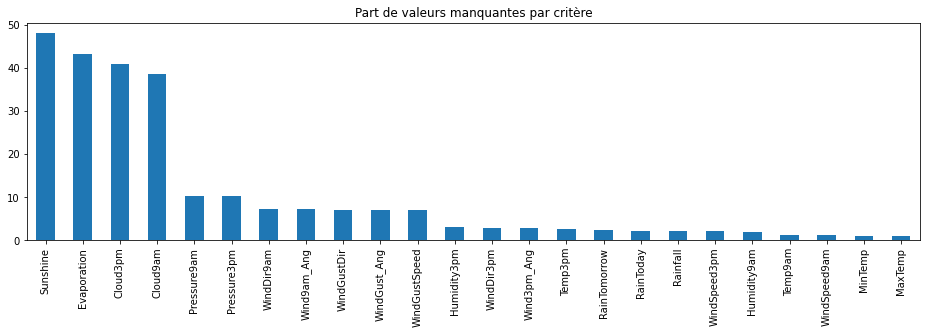

In [9]:
#Décompte des valeurs manquantes
percent_na = df.isna().sum() * 100 / len(df)
percent_na = percent_na.sort_values(ascending=False)

plt.figure(figsize=(16,4))
percent_na[percent_na > 0].plot(kind='bar')
plt.title("Part de valeurs manquantes par critère");

## a. Interpolation linéaires pour les valeurs manquantes autres que Sunshine, Evaporation, Cloud3pm, Cloud9am

In [10]:
# Définition des colonnes à interpoler
colInter=['MinTemp','MaxTemp','Rainfall','WindGustSpeed','WindSpeed9am','WindSpeed3pm','Humidity9am','Humidity3pm','Pressure9am','Pressure3pm','Temp9am','Temp3pm','WindGust_Ang','Wind9am_Ang','Wind3pm_Ang']

df_inter=df[colInter]

# Interpolation linéaire des Na pour les colonnes sélectionnées
df_inter.interpolate(method='linear',inplace=True)

# Transfert des colonnes sans NA dans df
df[colInter]=df_inter[colInter]



C:\Users\A021128\AppData\Local\Temp/ipykernel_9548/591094911.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inter.interpolate(method='linear',inplace=True)


In [11]:
#Re-définition des  variables correspondant au cosinos de l'angle (abscisse des coordonnées trigo). Un cosinus négatif correspond à un vent d'ouest, un cosinus positif à un vent d'est.
df['WindGust_cos'] = np.cos(np.radians(df['WindGust_Ang']))
df['Wind9am_cos'] = np.cos(np.radians(df['Wind9am_Ang']))
df['Wind3pm_cos'] = np.cos(np.radians(df['Wind3pm_Ang']))

#Re-définition des variables correspondant au sinus de l'angle (ordonnée des coordonnées trigo). Un sinus négatif correspond à un vent de sud, un sinus positif à un vent de nord.
df['WindGust_sin'] = np.sin(np.radians(df['WindGust_Ang']))
df['Wind9am_sin'] = np.sin(np.radians(df['Wind9am_Ang']))
df['Wind3pm_sin'] = np.sin(np.radians(df['Wind3pm_Ang']))

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 32 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        145460 non-null  float64
 3   MaxTemp        145460 non-null  float64
 4   Rainfall       145460 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  145460 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   145460 non-null  float64
 12  WindSpeed3pm   145460 non-null  float64
 13  Humidity9am    145460 non-null  float64
 14  Humidity3pm    145460 non-null  float64
 15  Pressure9am    145460 non-null  float64
 16  Pressure3pm    145460 non-null  float64
 17  Cloud9am       89572 non-null

- Forte proportion de valeurs manquantes (Sunshine/Evaporation/Cloud3pm/Cloud9am). A traiter avec un transformeur KNNImputer.

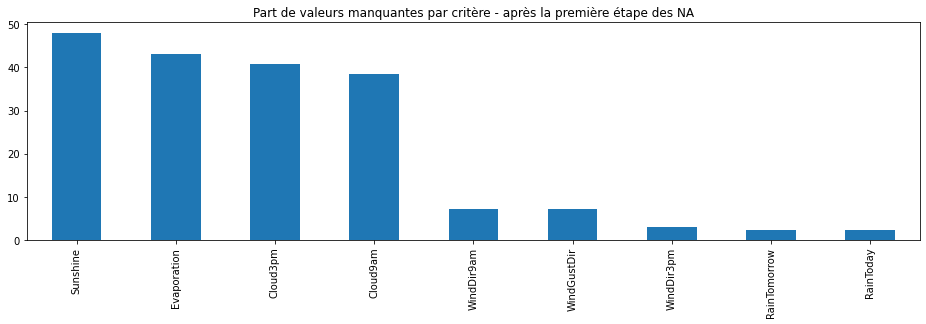

In [14]:
percent_na = df.isna().sum() * 100 / len(df)
percent_na = percent_na.sort_values(ascending=False)

plt.figure(figsize=(16,4))
percent_na[percent_na > 0].plot(kind='bar')
plt.title("Part de valeurs manquantes par critère - après la première étape des NA");

# b. Utilisation d'un transformeur KNN imputer

In [20]:
df_imputer=df.drop(['Date','Location','Climat_Koppen'],axis=1)
# import de KNNImputer
from sklearn.impute import KNNImputer
# définition du transformeur
imputer=KNNImputer(n_neighbors=5,weights='uniform',metric='nan_euclidean')
#fit du transformeur
imputer.fit(df_imputer)

df_trans=imputer.transform(df_imputer)

from numpy import isnan
print('Missing: %d' % sum(isnan(df_trans).flatten()))



Missing: 0


In [21]:
df_imputer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145460 entries, 96320 to 108570
Data columns (total 43 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   MinTemp             145460 non-null  float64
 1   MaxTemp             145460 non-null  float64
 2   Rainfall            145460 non-null  float64
 3   Evaporation         82670 non-null   float64
 4   Sunshine            75625 non-null   float64
 5   WindGustSpeed       145460 non-null  float64
 6   WindSpeed9am        145460 non-null  float64
 7   WindSpeed3pm        145460 non-null  float64
 8   Humidity9am         145460 non-null  float64
 9   Humidity3pm         145460 non-null  float64
 10  Pressure9am         145460 non-null  float64
 11  Pressure3pm         145460 non-null  float64
 12  Cloud9am            89572 non-null   float64
 13  Cloud3pm            86102 non-null   float64
 14  Temp9am             145460 non-null  float64
 15  Temp3pm             145460 non

In [22]:
df_final=df_imputer
df_final['Evaporation']=df_trans[:,3]
df_final['Sunshine']=df_trans[:,4]
df_final['Cloud9am']=df_trans[:,12]
df_final['Cloud3pm']=df_trans[:,13]
df_final['Date']=df['Date']
df_final['Location']=df['Location']
df_final['Climat_Koppen']=df['Climat_Koppen']

In [23]:
# Statut des NA pour chaque colonne

for i in df_final:
    # comptage du nb de NA dans chaque colonne
    n_miss = df_final[i].isnull().sum()
    perc = n_miss / df_final.shape[0] * 100 
    print(f"La colonne {i} contient {n_miss} valeurs manquantes soit {perc:.2f} %")

La colonne MinTemp contient 0 valeurs manquantes soit 0.00 %
La colonne MaxTemp contient 0 valeurs manquantes soit 0.00 %
La colonne Rainfall contient 0 valeurs manquantes soit 0.00 %
La colonne Evaporation contient 0 valeurs manquantes soit 0.00 %
La colonne Sunshine contient 0 valeurs manquantes soit 0.00 %
La colonne WindGustSpeed contient 0 valeurs manquantes soit 0.00 %
La colonne WindSpeed9am contient 0 valeurs manquantes soit 0.00 %
La colonne WindSpeed3pm contient 0 valeurs manquantes soit 0.00 %
La colonne Humidity9am contient 0 valeurs manquantes soit 0.00 %
La colonne Humidity3pm contient 0 valeurs manquantes soit 0.00 %
La colonne Pressure9am contient 0 valeurs manquantes soit 0.00 %
La colonne Pressure3pm contient 0 valeurs manquantes soit 0.00 %
La colonne Cloud9am contient 0 valeurs manquantes soit 0.00 %
La colonne Cloud3pm contient 0 valeurs manquantes soit 0.00 %
La colonne Temp9am contient 0 valeurs manquantes soit 0.00 %
La colonne Temp3pm contient 0 valeurs manquan

## g. Suppression des derniers valeurs manquantes

In [24]:
df_final=df_final.dropna()
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145455 entries, 96322 to 108567
Data columns (total 46 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   MinTemp             145455 non-null  float64       
 1   MaxTemp             145455 non-null  float64       
 2   Rainfall            145455 non-null  float64       
 3   Evaporation         145455 non-null  float64       
 4   Sunshine            145455 non-null  float64       
 5   WindGustSpeed       145455 non-null  float64       
 6   WindSpeed9am        145455 non-null  float64       
 7   WindSpeed3pm        145455 non-null  float64       
 8   Humidity9am         145455 non-null  float64       
 9   Humidity3pm         145455 non-null  float64       
 10  Pressure9am         145455 non-null  float64       
 11  Pressure3pm         145455 non-null  float64       
 12  Cloud9am            145455 non-null  float64       
 13  Cloud3pm            14545

# 5. Création du dataset final

In [26]:
df_final['Cloud9am']=df_final['Cloud9am'].astype(int)
df_final['Cloud3pm']=df_final['Cloud3pm'].astype(int)
df_final.to_csv('weatherAUS_imputer.csv')

<ipython-input-26-7efb810c0729>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Cloud9am']=df_final['Cloud9am'].astype(int)
<ipython-input-26-7efb810c0729>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Cloud3pm']=df_final['Cloud3pm'].astype(int)


In [27]:
df_final.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Mois_sin,Mois_cos,clim_méditerranéen,clim_océanique,clim_sec,clim_subtropical,clim_tropical,Date,Location,Climat_Koppen
96322,6.2,15.1,0.0,1.80,2.1,20.0,2.0,11.0,81.0,56.0,...,-0.281733,-0.959493,1,0,0,0,0,2008-07-03,Adelaide,Csa
96323,5.3,15.9,0.0,1.40,8.0,30.0,6.0,13.0,71.0,46.0,...,-0.281733,-0.959493,1,0,0,0,0,2008-07-04,Adelaide,Csa
96324,9.8,15.4,0.0,2.24,0.9,30.0,9.0,9.0,56.0,67.0,...,-0.281733,-0.959493,1,0,0,0,0,2008-07-05,Adelaide,Csa
96325,11.3,15.7,8.1,3.32,1.5,52.0,15.0,22.0,62.0,62.0,...,-0.281733,-0.959493,1,0,0,0,0,2008-07-06,Adelaide,Csa
96326,7.6,11.2,16.2,4.60,1.1,46.0,17.0,13.0,83.0,88.0,...,-0.281733,-0.959493,1,0,0,0,0,2008-07-07,Adelaide,Csa
